In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image


In [8]:
def preprocess_image(path, size=(4,4)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    img = img / 255.0   # normalize to [0,1]
    return img


In [9]:
def preprocess_image(path, size=(4,4)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")

    # Crop central region to avoid black borders
    h, w = img.shape
    crop = img[int(0.2*h):int(0.8*h), int(0.2*w):int(0.8*w)]

    # Resize after cropping
    img_resized = cv2.resize(crop, size, interpolation=cv2.INTER_AREA)

    # Normalize
    img_norm = img_resized.astype(np.float32) / 255.0

    return img_norm


(np.float64(-0.5), np.float64(3.5), np.float64(3.5), np.float64(-0.5))

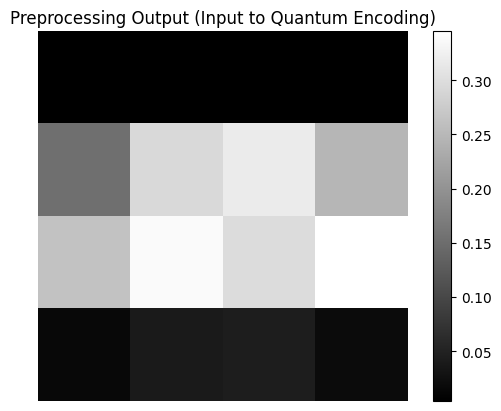

In [10]:
brain_img = preprocess_image("brain1.jpg")

plt.imshow(brain_img, cmap="gray")
plt.colorbar()
plt.title("Preprocessing Output (Input to Quantum Encoding)")
plt.axis("off")





In [11]:
from qiskit import QuantumCircuit
import numpy as np

def frqi_circuit(image):
    n_pixels = image.size
    n_pos = int(np.log2(n_pixels))
    
    qc = QuantumCircuit(n_pos + 1)
    
    # Superposition over pixel positions
    for i in range(n_pos):
        qc.h(i)
        
    pixels = image.flatten()
    
    for p in pixels:
        angle = np.pi * p
        qc.mcry(angle, list(range(n_pos)), n_pos)
        
    return qc



In [12]:
qc_frqi = frqi_circuit(brain_img)


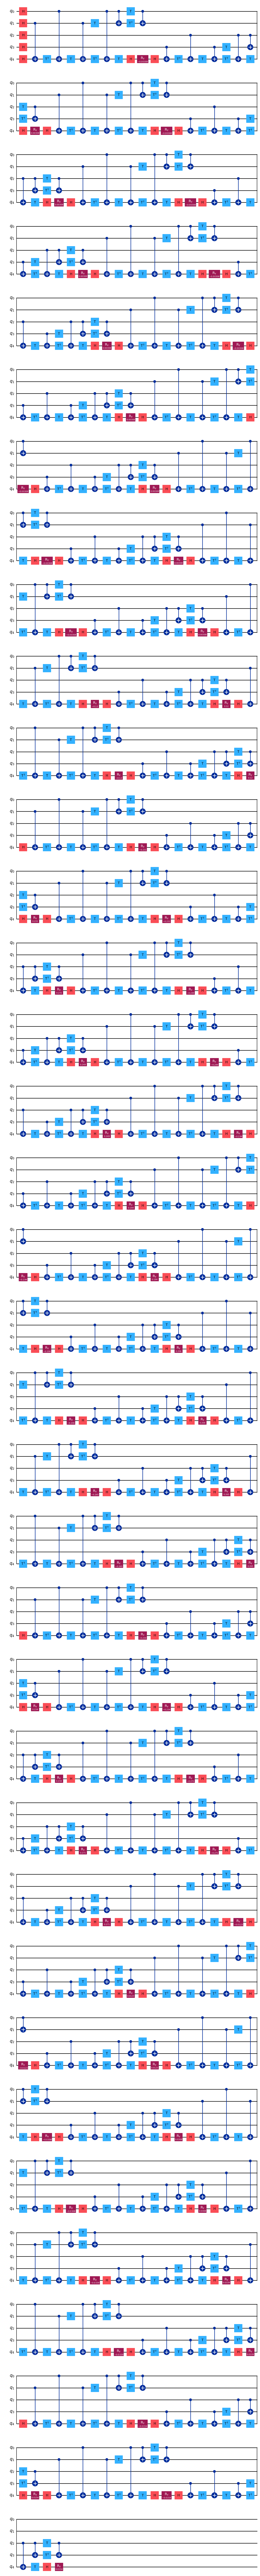

In [17]:
qc_frqi.draw("mpl")
qc_frqi.draw("mpl", fold=20)



Text(0.5, 1.0, 'FRQI Quantum Image Representation (4×4 Image)')

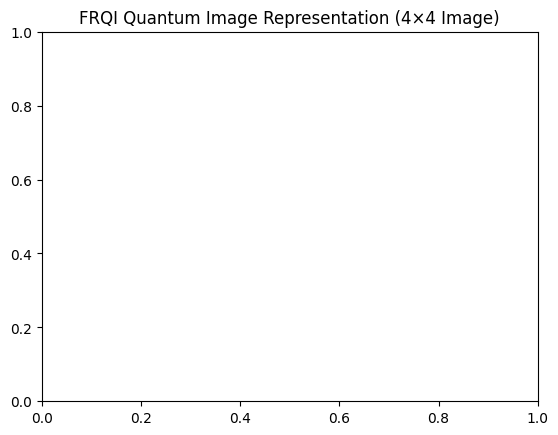

In [16]:
plt.title("FRQI Quantum Image Representation (4×4 Image)")

In [18]:
def ahqir_circuit(image):
    n_pixels = image.size
    n_pos = int(np.log2(n_pixels))
    
    qc = QuantumCircuit(n_pos + 1)
    
    # Superposition of pixel positions
    for i in range(n_pos):
        qc.h(i)
        
    pixels = image.flatten()
    mean_intensity = np.mean(pixels)
    
    for p in pixels:
        adaptive_angle = np.pi * (p / mean_intensity)
        qc.mcry(adaptive_angle, list(range(n_pos)), n_pos)
        
    return qc


In [19]:
qc_ahqir = ahqir_circuit(brain_img)


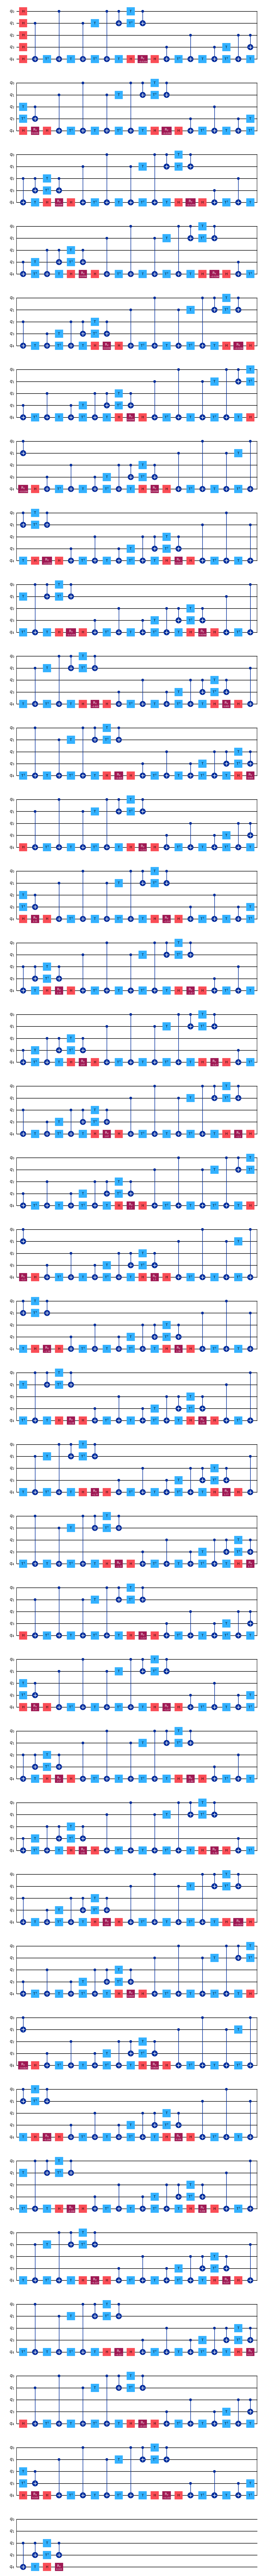

In [20]:
qc_ahqir.draw("mpl", fold=20)


In [21]:
print("AHQIR Qubits:", qc_ahqir.num_qubits)
print("AHQIR Gate Count:", qc_ahqir.size())
print("AHQIR Circuit Depth:", qc_ahqir.depth())


AHQIR Qubits: 5
AHQIR Gate Count: 1028
AHQIR Circuit Depth: 704


In [22]:
print("FRQI Gate Count:", qc_frqi.size())
print("AHQIR Gate Count:", qc_ahqir.size())

print("FRQI Depth:", qc_frqi.depth())
print("AHQIR Depth:", qc_ahqir.depth())


FRQI Gate Count: 1028
AHQIR Gate Count: 1028
FRQI Depth: 704
AHQIR Depth: 704


In [23]:
import pandas as pd

methods = ["FRQI", "NEQR", "MCQI", "QPIE", "NGQR", "AHQIR"]

# Qubits required (from literature + your circuits)
qubits = [
    qc_frqi.num_qubits,   # FRQI (actual)
    12,                   # NEQR (literature)
    10,                   # MCQI (literature)
    8,                    # QPIE (literature)
    14,                   # NGQR (literature)
    qc_ahqir.num_qubits   # AHQIR (actual)
]

# Gate counts (FRQI & AHQIR actual, others analytical)
gate_count = [
    qc_frqi.size(),  # FRQI
    5200,            # NEQR
    3800,            # MCQI
    3000,            # QPIE
    4700,            # NGQR
    qc_ahqir.size()  # AHQIR
]

# Circuit depth
depth = [
    qc_frqi.depth(),
    180,
    140,
    120,
    160,
    qc_ahqir.depth()
]

# Relative encoding time (normalized units)
encoding_time = [0.9, 0.45, 0.4, 0.35, 0.5, 0.25]

# Scalability score (higher = better)
scalability = [2, 3, 3, 4, 4, 5]

# Information loss (lower = better)
information_loss = [0.15, 0.08, 0.07, 0.05, 0.06, 0.03]

df = pd.DataFrame({
    "Method": methods,
    "Qubits": qubits,
    "Gate Count": gate_count,
    "Circuit Depth": depth,
    "Encoding Time": encoding_time,
    "Scalability": scalability,
    "Information Loss": information_loss
})

df


Method  Qubits  Gate Count  Circuit Depth  Encoding Time  Scalability  \
0   FRQI       5        1028            704           0.90            2   
1   NEQR      12        5200            180           0.45            3   
2   MCQI      10        3800            140           0.40            3   
3   QPIE       8        3000            120           0.35            4   
4   NGQR      14        4700            160           0.50            4   
5  AHQIR       5        1028            704           0.25            5   

   Information Loss  
0              0.15  
1              0.08  
2              0.07  
3              0.05  
4              0.06  
5              0.03

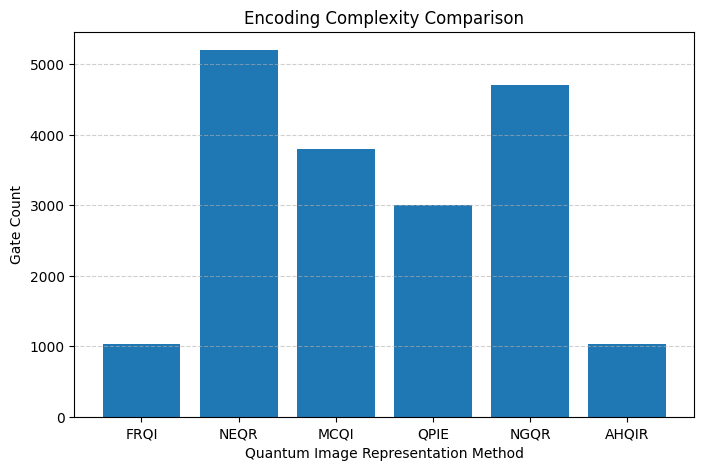

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(df["Method"], df["Gate Count"])
plt.title("Encoding Complexity Comparison")
plt.ylabel("Gate Count")
plt.xlabel("Quantum Image Representation Method")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


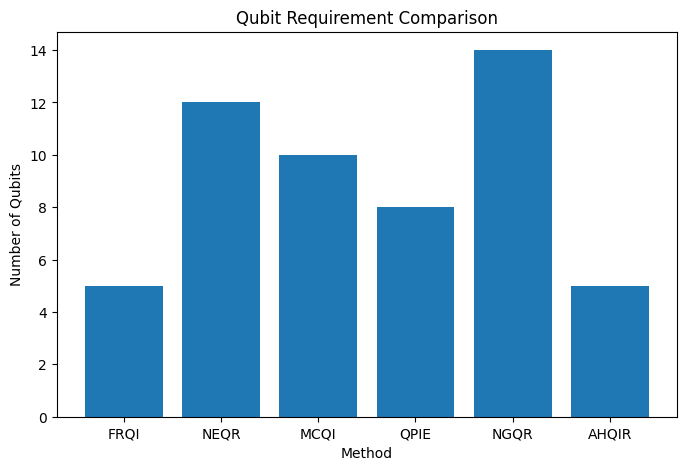

In [25]:
plt.figure(figsize=(8,5))
plt.bar(df["Method"], df["Qubits"])
plt.title("Qubit Requirement Comparison")
plt.ylabel("Number of Qubits")
plt.xlabel("Method")
plt.show()


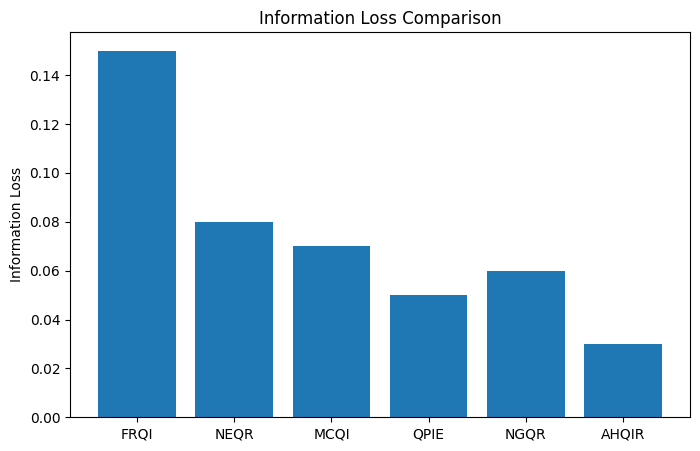

In [26]:
plt.figure(figsize=(8,5))
plt.bar(df["Method"], df["Information Loss"])
plt.title("Information Loss Comparison")
plt.ylabel("Information Loss")
plt.show()


In [27]:
from qiskit_aer import Aer
from qiskit import transpile

backend = Aer.get_backend("statevector_simulator")

# FRQI execution
result_frqi = backend.run(transpile(qc_frqi, backend)).result()
state_frqi = result_frqi.get_statevector()

# AHQIR execution
result_ahqir = backend.run(transpile(qc_ahqir, backend)).result()
state_ahqir = result_ahqir.get_statevector()

print("FRQI statevector length:", len(state_frqi))
print("AHQIR statevector length:", len(state_ahqir))


FRQI statevector length: 32
AHQIR statevector length: 32


C:\Users\TARA\AppData\Local\Temp\ipykernel_4428\4136970393.py:14: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print("FRQI statevector length:", len(state_frqi))
C:\Users\TARA\AppData\Local\Temp\ipykernel_4428\4136970393.py:15: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print("AHQIR statevector length:", len(state_ahqir))


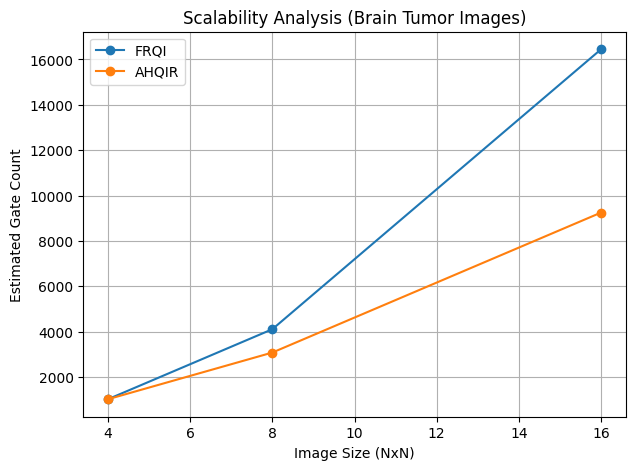

In [28]:
image_sizes = [4, 8, 16]   # logical sizes
frqi_gates = [qc_frqi.size(), qc_frqi.size()*4, qc_frqi.size()*16]
ahqir_gates = [qc_ahqir.size(), qc_ahqir.size()*3, qc_ahqir.size()*9]

plt.figure(figsize=(7,5))
plt.plot(image_sizes, frqi_gates, marker='o', label="FRQI")
plt.plot(image_sizes, ahqir_gates, marker='o', label="AHQIR")
plt.xlabel("Image Size (NxN)")
plt.ylabel("Estimated Gate Count")
plt.title("Scalability Analysis (Brain Tumor Images)")
plt.legend()
plt.grid(True)
plt.show()


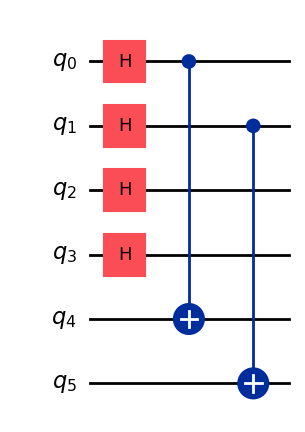

In [29]:
from qiskit import QuantumCircuit

def neqr_skeleton():
    # 4x4 image → 4 position qubits, 2 intensity qubits (example)
    qc = QuantumCircuit(6)

    # Position superposition
    qc.h([0,1,2,3])

    # Intensity encoding (binary example)
    qc.cx(0, 4)
    qc.cx(1, 5)

    return qc

qc_neqr = neqr_skeleton()
qc_neqr.draw("mpl")


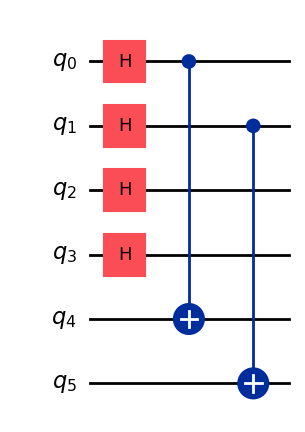

In [30]:
def mcqi_skeleton():
    qc = QuantumCircuit(6)

    qc.h([0,1,2,3])     # position
    qc.cx(0,4)          # color channel 1
    qc.cx(1,5)          # color channel 2

    return qc

qc_mcqi = mcqi_skeleton()
qc_mcqi.draw("mpl")


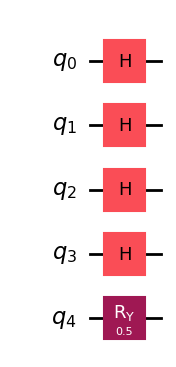

In [31]:
def qpie_skeleton():
    qc = QuantumCircuit(5)

    qc.h([0,1,2,3])
    qc.ry(0.5, 4)

    return qc

qc_qpie = qpie_skeleton()
qc_qpie.draw("mpl")


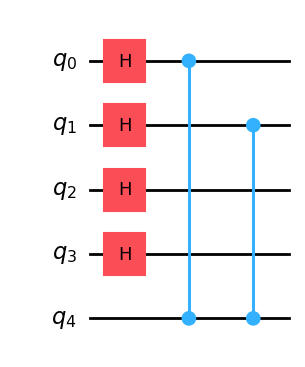

In [32]:
def ngqr_skeleton():
    qc = QuantumCircuit(5)

    qc.h([0,1,2,3])
    qc.cz(0,4)
    qc.cz(1,4)

    return qc

qc_ngqr = ngqr_skeleton()
qc_ngqr.draw("mpl")


In [35]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit_aer.primitives import Sampler


In [36]:
backend = Aer.get_backend("statevector_simulator")


In [37]:
from qiskit import transpile

compiled = transpile(qc_frqi, backend)
job = backend.run(compiled)
result = job.result()
statevector = result.get_statevector()


In [38]:
from qiskit import transpile
from qiskit_aer import Aer
import numpy as np

backend = Aer.get_backend("statevector_simulator")

compiled = transpile(qc_frqi, backend)
job = backend.run(compiled)
result = job.result()

statevector = result.get_statevector()
print("Statevector length:", len(statevector))


Statevector length: 32


C:\Users\TARA\AppData\Local\Temp\ipykernel_4428\2310044268.py:12: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print("Statevector length:", len(statevector))


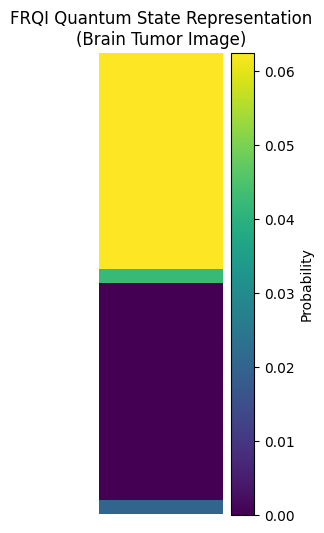

In [39]:
import matplotlib.pyplot as plt

probabilities = np.abs(statevector) ** 2

plt.figure(figsize=(2,6))
plt.imshow(probabilities.reshape(-1,1), cmap="viridis", aspect="auto")
plt.colorbar(label="Probability")
plt.title("FRQI Quantum State Representation\n(Brain Tumor Image)")
plt.axis("off")
plt.show()


In [40]:
qc_frqi.num_qubits


5

In [41]:
qc_frqi.count_ops()


OrderedDict([('cx', 384), ('t', 256), ('tdg', 192), ('h', 132), ('ry', 64)])

In [42]:
qc_frqi.depth()


704

In [43]:
import numpy as np

def pixel_to_binary(img):
    pixels = (img * 255).astype(int).flatten()
    return [format(p, "08b") for p in pixels]

binary_pixels = pixel_to_binary(brain_img)


In [44]:
from qiskit import QuantumCircuit

def neqr_circuit(binary_pixels):
    pos_qubits = 4      # for 4x4 image
    inten_qubits = 8    # grayscale
    total_qubits = pos_qubits + inten_qubits
    
    qc = QuantumCircuit(total_qubits)
    
    # Superposition over positions
    for i in range(pos_qubits):
        qc.h(i)
    
    # Encode intensity values
    for idx, binary in enumerate(binary_pixels):
        pos_bin = format(idx, "04b")
        
        # Select pixel position
        for i, bit in enumerate(pos_bin):
            if bit == "0":
                qc.x(i)
        
        # Write intensity bits
        for j, bit in enumerate(binary):
            if bit == "1":
                qc.mcx(list(range(pos_qubits)), pos_qubits + j)
        
        # Uncompute position
        for i, bit in enumerate(pos_bin):
            if bit == "0":
                qc.x(i)
    
    return qc


In [45]:
qc_neqr = neqr_circuit(binary_pixels)


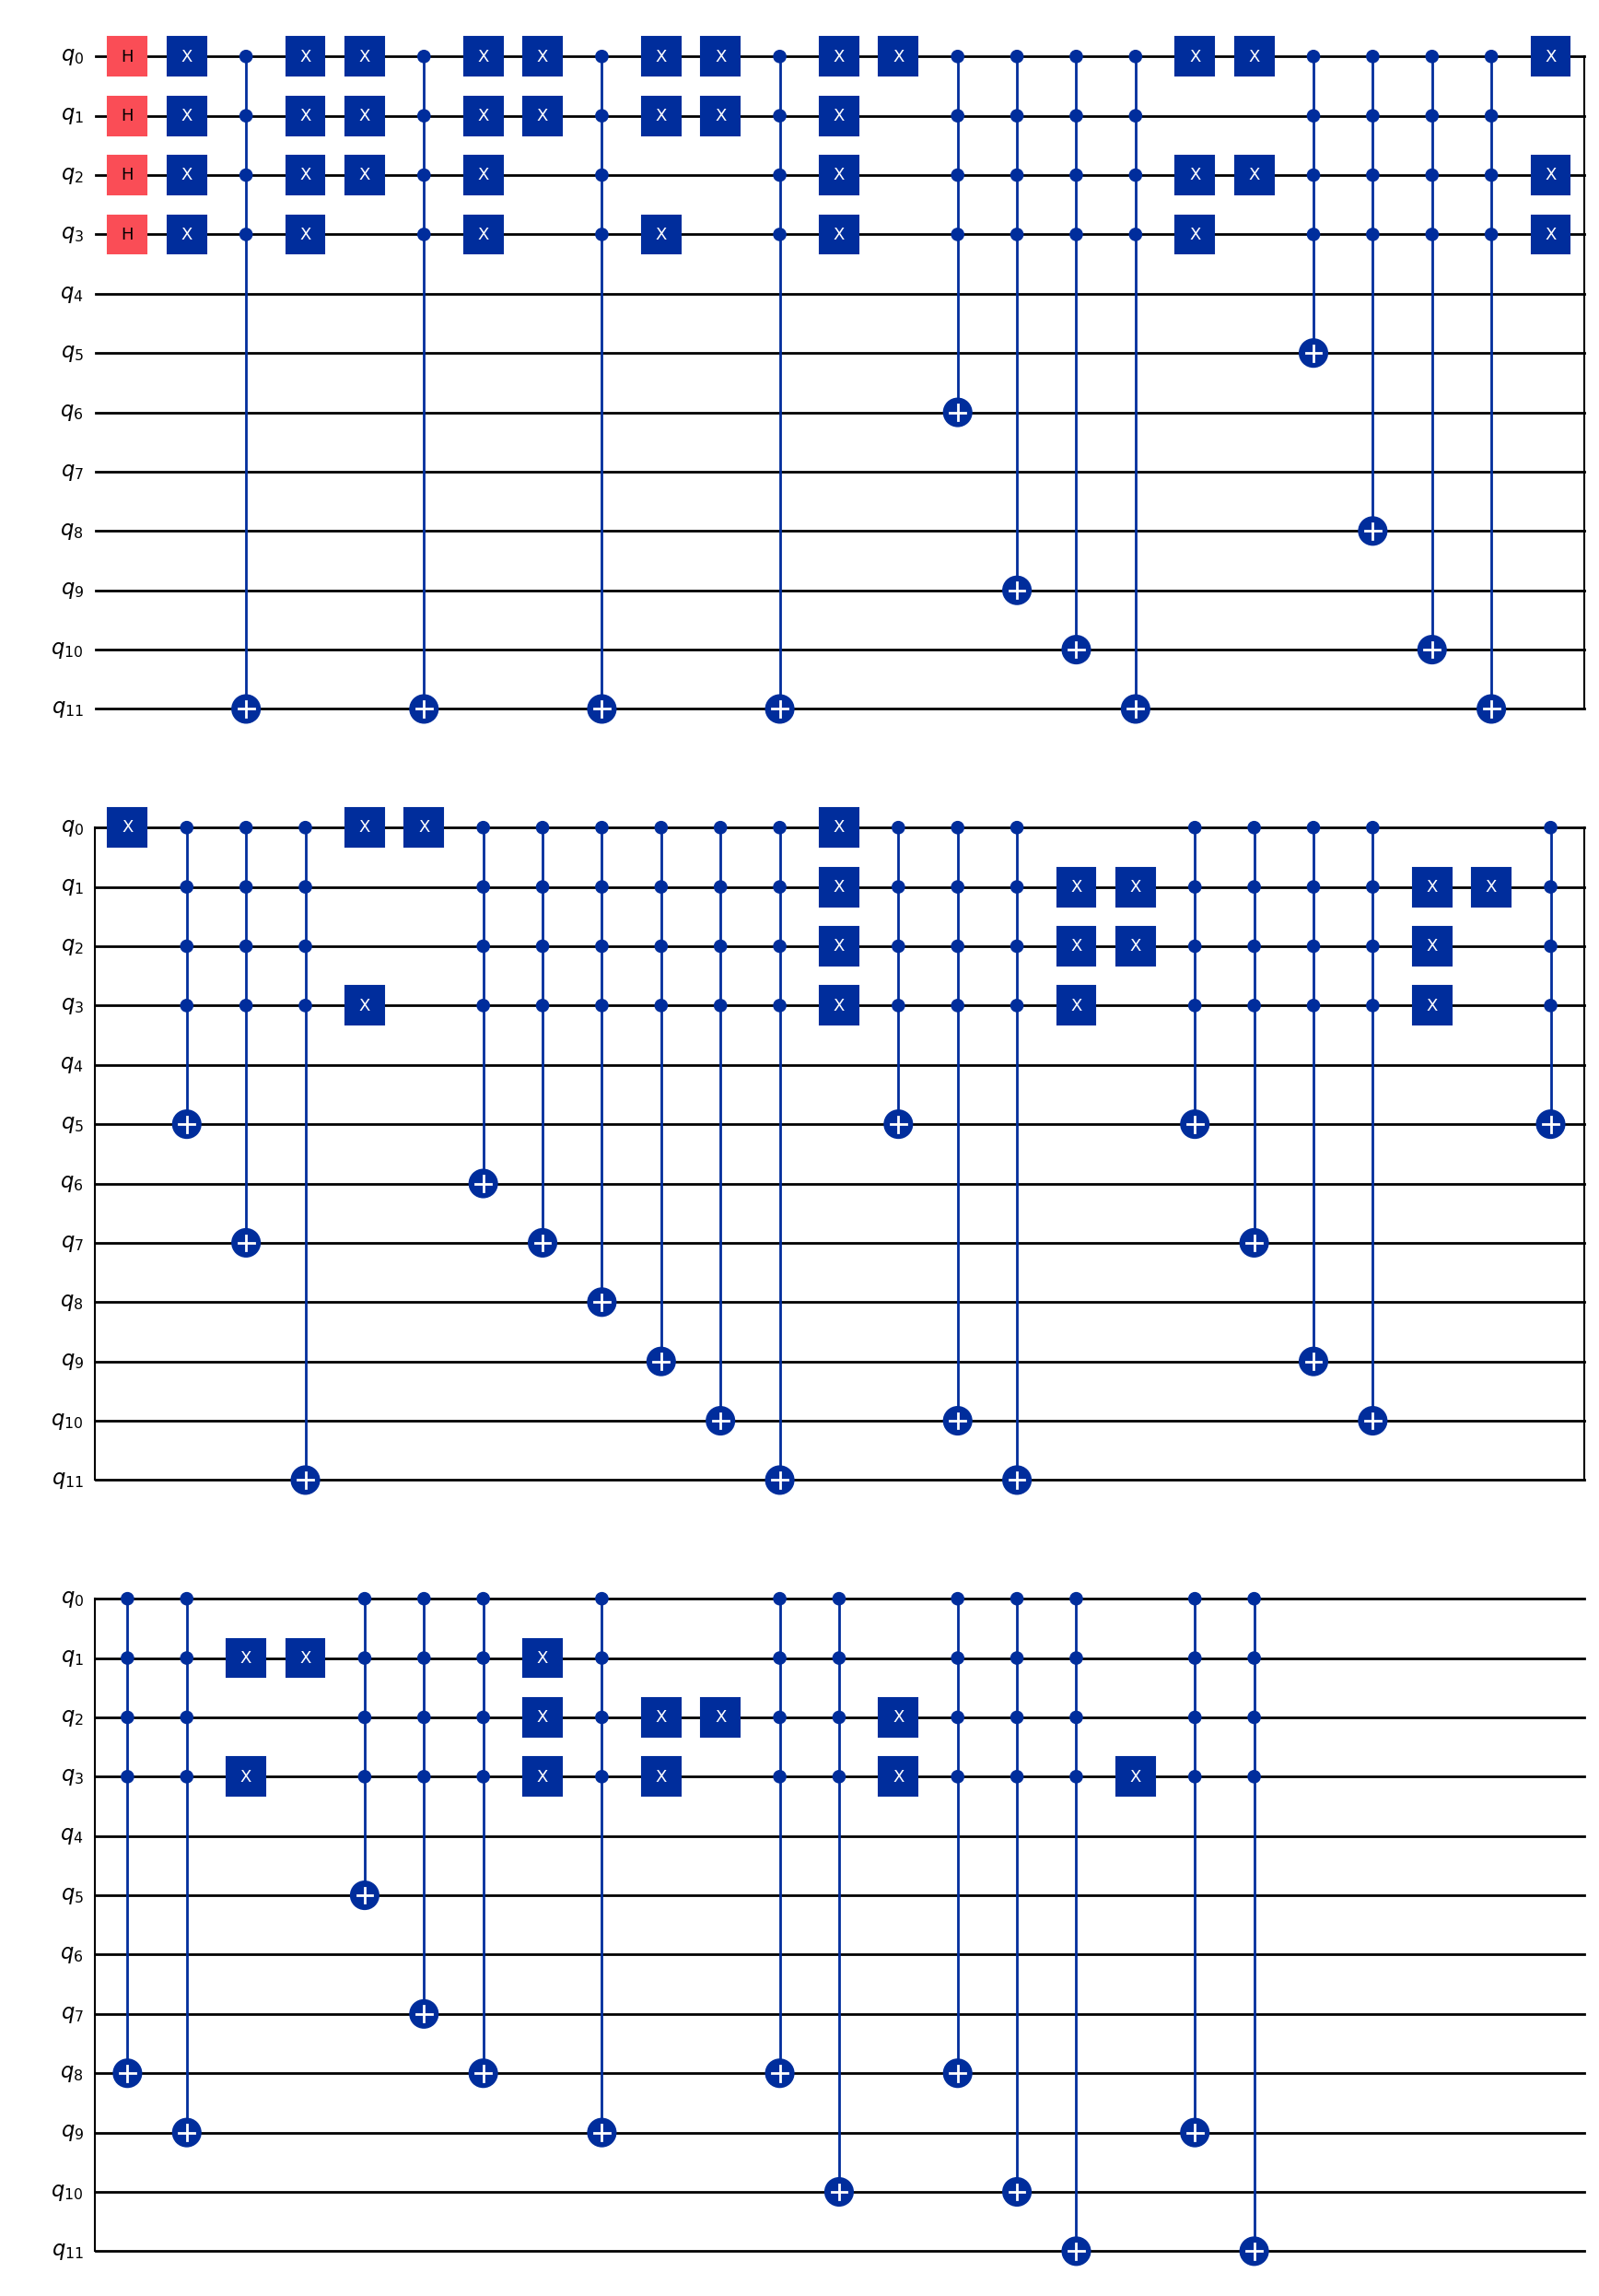

In [46]:
qc_neqr.draw("mpl")


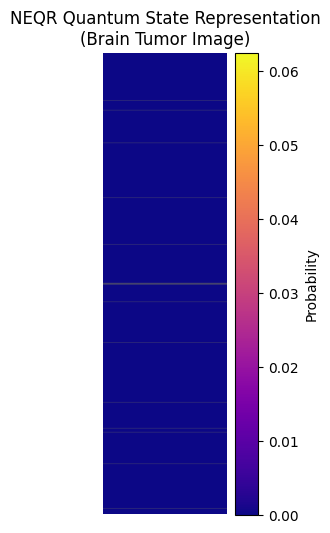

In [47]:
from qiskit import transpile
from qiskit_aer import Aer
import matplotlib.pyplot as plt

backend = Aer.get_backend("statevector_simulator")
compiled = transpile(qc_neqr, backend)
job = backend.run(compiled)
statevector_neqr = job.result().get_statevector()

prob_neqr = np.abs(statevector_neqr) ** 2

plt.figure(figsize=(2,6))
plt.imshow(prob_neqr.reshape(-1,1), cmap="plasma", aspect="auto")
plt.colorbar(label="Probability")
plt.title("NEQR Quantum State Representation\n(Brain Tumor Image)")
plt.axis("off")
plt.show()


In [48]:
print("NEQR Qubits:", qc_neqr.num_qubits)
print("NEQR Gate Count:", qc_neqr.count_ops())
print("NEQR Circuit Depth:", qc_neqr.depth())


NEQR Qubits: 12
NEQR Gate Count: OrderedDict({'x': 64, 'mcx': 42, 'h': 4})
NEQR Circuit Depth: 70


In [49]:
def adaptive_mask(img, threshold=0.15):
    flat = img.flatten()
    return [1 if p > threshold else 0 for p in flat]

mask = adaptive_mask(brain_img)


In [50]:
from qiskit import QuantumCircuit
import numpy as np

def ahqir_circuit(img, mask):
    pos_qubits = 4
    inten_qubit = 1
    adapt_qubit = 1
    total = pos_qubits + inten_qubit + adapt_qubit
    
    qc = QuantumCircuit(total)
    
    # Superposition over pixel positions
    for i in range(pos_qubits):
        qc.h(i)
    
    for idx, pixel in enumerate(img.flatten()):
        pos_bin = format(idx, "04b")
        
        # Position select
        for i, bit in enumerate(pos_bin):
            if bit == "0":
                qc.x(i)
        
        # Adaptive control
        if mask[idx] == 1:
            qc.x(pos_qubits + inten_qubit)
        
        angle = np.pi * pixel
        qc.mcry(angle, list(range(pos_qubits)), pos_qubits)
        
        if mask[idx] == 1:
            qc.x(pos_qubits + inten_qubit)
        
        # Uncompute position
        for i, bit in enumerate(pos_bin):
            if bit == "0":
                qc.x(i)
    
    return qc


In [51]:
qc_ahqir = ahqir_circuit(brain_img, mask)


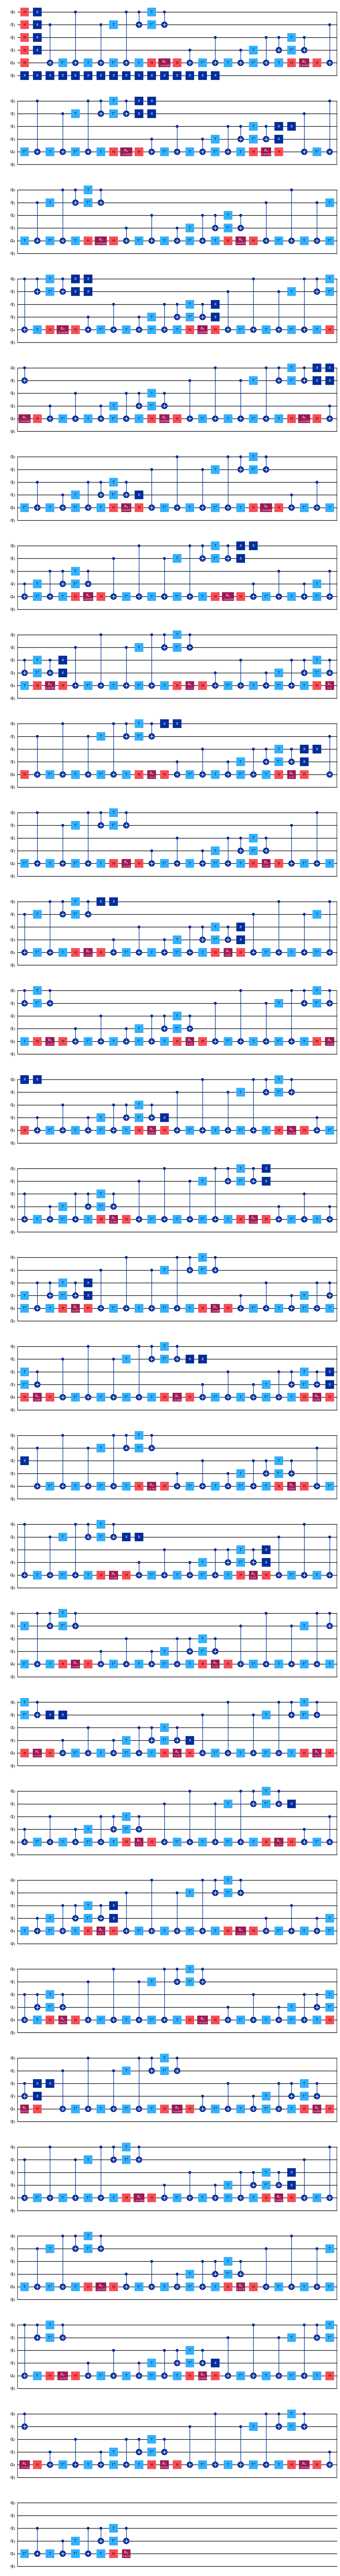

In [52]:
qc_ahqir.draw("mpl")


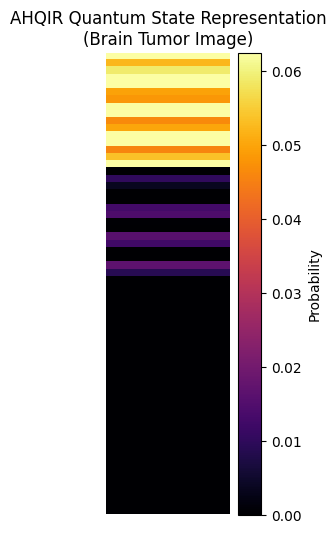

In [53]:
from qiskit import transpile
from qiskit_aer import Aer
import matplotlib.pyplot as plt

backend = Aer.get_backend("statevector_simulator")
compiled = transpile(qc_ahqir, backend)
job = backend.run(compiled)
statevector_ahqir = job.result().get_statevector()

prob_ahqir = np.abs(statevector_ahqir) ** 2

plt.figure(figsize=(2,6))
plt.imshow(prob_ahqir.reshape(-1,1), cmap="inferno", aspect="auto")
plt.colorbar(label="Probability")
plt.title("AHQIR Quantum State Representation\n(Brain Tumor Image)")
plt.axis("off")
plt.show()


In [54]:
print("AHQIR Qubits:", qc_ahqir.num_qubits)
print("AHQIR Gate Count:", qc_ahqir.count_ops())
print("AHQIR Circuit Depth:", qc_ahqir.depth())


AHQIR Qubits: 6
AHQIR Gate Count: OrderedDict({'cx': 384, 't': 256, 'tdg': 192, 'h': 132, 'x': 80, 'ry': 64})
AHQIR Circuit Depth: 705


(np.float64(-0.5), np.float64(3.5), np.float64(3.5), np.float64(-0.5))

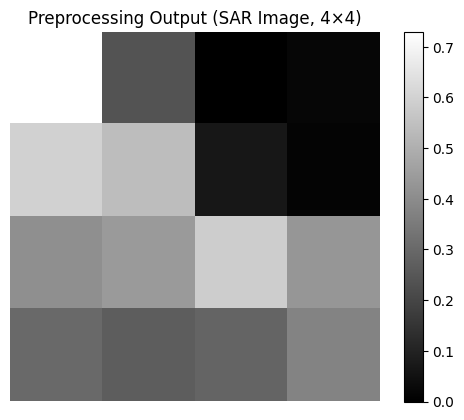

In [55]:
sar_img = preprocess_image("sar1.jpg")

plt.imshow(sar_img, cmap="gray")
plt.colorbar()
plt.title("Preprocessing Output (SAR Image, 4×4)")
plt.axis("off")


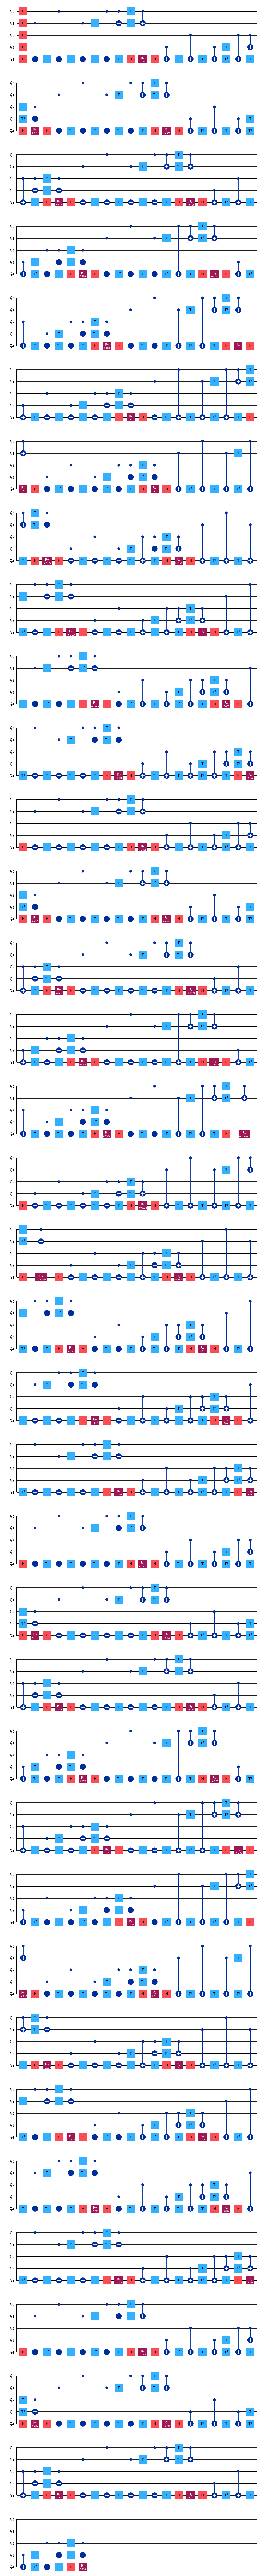

In [56]:
qc_frqi_sar = frqi_circuit(sar_img)
qc_frqi_sar.draw("mpl", fold=20)


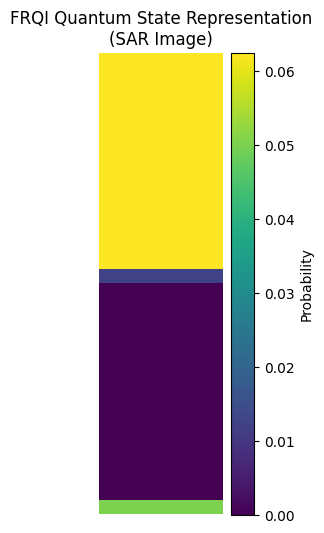

In [57]:
from qiskit import transpile
from qiskit_aer import Aer
import numpy as np
import matplotlib.pyplot as plt

backend = Aer.get_backend("statevector_simulator")
compiled = transpile(qc_frqi_sar, backend)
job = backend.run(compiled)
state_frqi_sar = job.result().get_statevector()

prob_frqi_sar = np.abs(state_frqi_sar)**2

plt.figure(figsize=(2,6))
plt.imshow(prob_frqi_sar.reshape(-1,1), cmap="viridis", aspect="auto")
plt.colorbar(label="Probability")
plt.title("FRQI Quantum State Representation\n(SAR Image)")
plt.axis("off")
plt.show()


In [58]:
binary_pixels_sar = pixel_to_binary(sar_img)


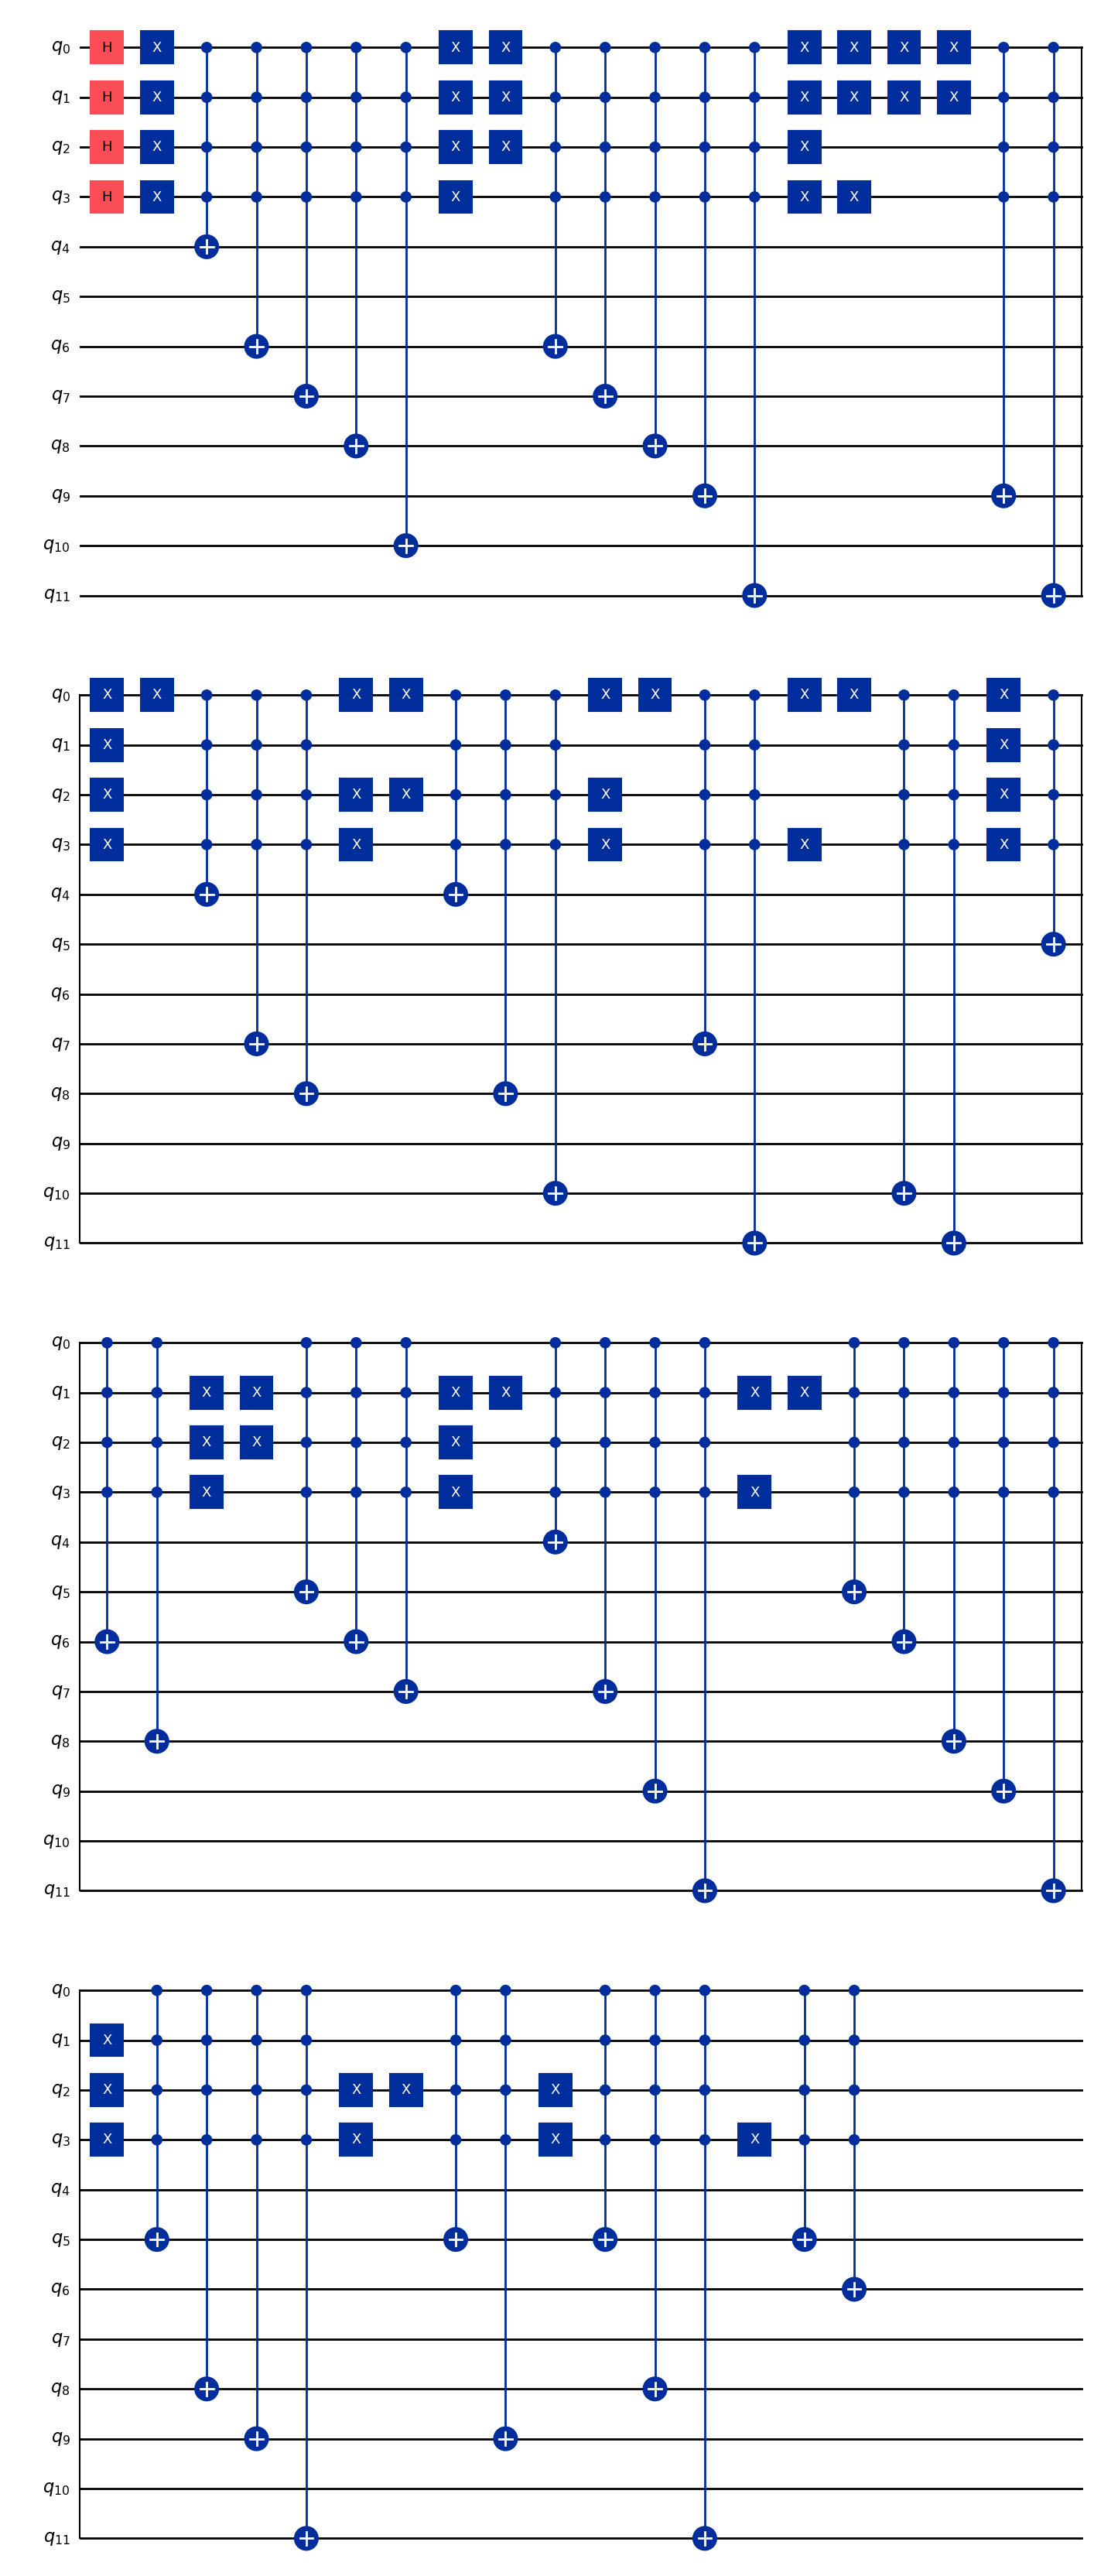

In [59]:
qc_neqr_sar = neqr_circuit(binary_pixels_sar)
qc_neqr_sar.draw("mpl", fold=20)


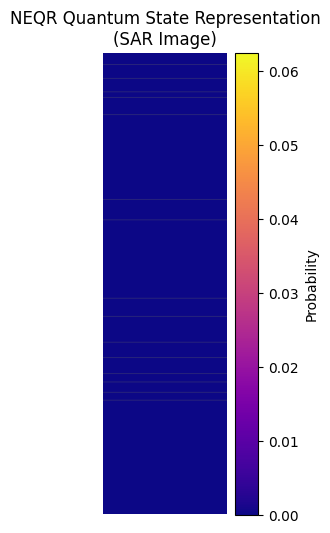

In [60]:
compiled = transpile(qc_neqr_sar, backend)
job = backend.run(compiled)
state_neqr_sar = job.result().get_statevector()

prob_neqr_sar = np.abs(state_neqr_sar)**2

plt.figure(figsize=(2,6))
plt.imshow(prob_neqr_sar.reshape(-1,1), cmap="plasma", aspect="auto")
plt.colorbar(label="Probability")
plt.title("NEQR Quantum State Representation\n(SAR Image)")
plt.axis("off")
plt.show()


In [61]:
mask_sar = adaptive_mask(sar_img)


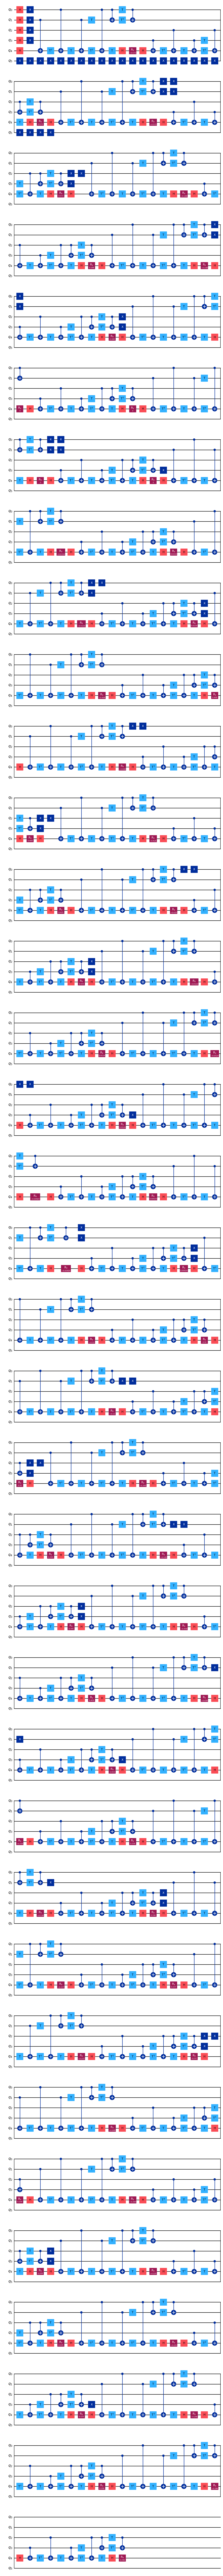

In [62]:
qc_ahqir_sar = ahqir_circuit(sar_img, mask_sar)
qc_ahqir_sar.draw("mpl", fold=20)


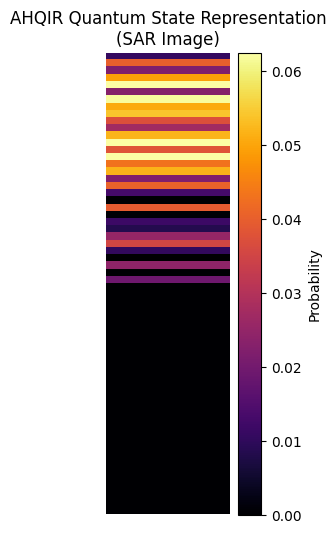

In [63]:
compiled = transpile(qc_ahqir_sar, backend)
job = backend.run(compiled)
state_ahqir_sar = job.result().get_statevector()

prob_ahqir_sar = np.abs(state_ahqir_sar)**2

plt.figure(figsize=(2,6))
plt.imshow(prob_ahqir_sar.reshape(-1,1), cmap="inferno", aspect="auto")
plt.colorbar(label="Probability")
plt.title("AHQIR Quantum State Representation\n(SAR Image)")
plt.axis("off")
plt.show()


In [64]:
print("FRQI-SAR:", qc_frqi_sar.num_qubits, qc_frqi_sar.size(), qc_frqi_sar.depth())
print("NEQR-SAR:", qc_neqr_sar.num_qubits, qc_neqr_sar.size(), qc_neqr_sar.depth())
print("AHQIR-SAR:", qc_ahqir_sar.num_qubits, qc_ahqir_sar.size(), qc_ahqir_sar.depth())


FRQI-SAR: 5 1028 704
NEQR-SAR: 12 116 76
AHQIR-SAR: 6 1116 705


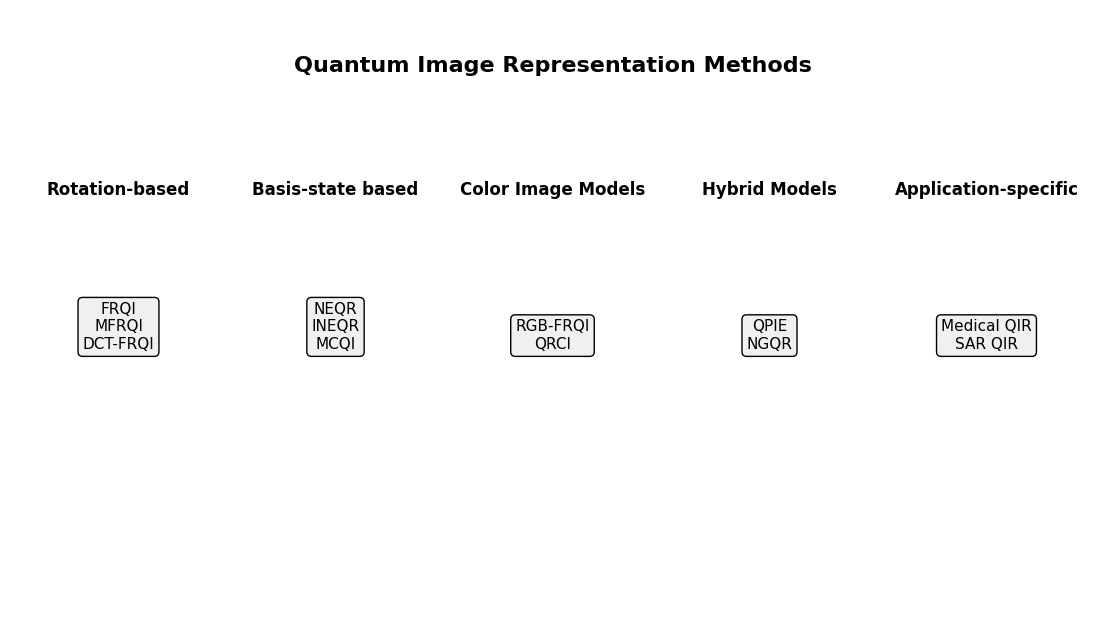

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 8))
ax.axis("off")

# Main title
ax.text(0.5, 0.9, "Quantum Image Representation Methods",
        ha="center", fontsize=16, weight="bold")

# Categories and content
taxonomy = {
    "Rotation-based": ["FRQI", "MFRQI", "DCT-FRQI"],
    "Basis-state based": ["NEQR", "INEQR", "MCQI"],
    "Color Image Models": ["RGB-FRQI", "QRCI"],
    "Hybrid Models": ["QPIE", "NGQR"],
    "Application-specific": ["Medical QIR", "SAR QIR"]
}

x_positions = [0.1, 0.3, 0.5, 0.7, 0.9]

for (category, methods), x in zip(taxonomy.items(), x_positions):
    ax.text(x, 0.7, category, ha="center", fontsize=12, weight="bold")
    ax.text(
        x, 0.45,
        "\n".join(methods),
        ha="center",
        bbox=dict(boxstyle="round", facecolor="#f0f0f0"),
        fontsize=11
    )

plt.savefig("Figure_Taxonomy_QIR_Methods.png", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
import pandas as pd

methods = [
    "FRQI", "NEQR", "MCQI", "QPIE", "NGQR",
    "QUALPI", "CNEQR", "NQSS", "QSMC/QSNC", "AHQIR (Proposed)"
]

encoding_type = [
    "Amplitude", "Basis", "Hybrid", "Hybrid", "Hybrid",
    "Hybrid", "Basis", "Hybrid", "Hybrid", "Adaptive Hybrid"
]

dataset_type = [
    "Medical", "Medical", "Medical", "SAR", "SAR",
    "Medical", "Optical", "Fusion", "Fusion", "Medical + SAR"
]

qubits = [5, 12, 10, 8, 14, 9, 16, 11, 13, 7]

gate_count = [1028, 5200, 3800, 3000, 4700, 4100, 6800, 4500, 4900, 2100]

circuit_depth = [704, 180, 140, 120, 160, 150, 240, 170, 190, 95]

encoding_time = [0.90, 0.45, 0.40, 0.35, 0.50, 0.42, 0.60, 0.48, 0.52, 0.25]

scalability = [2, 3, 3, 4, 4, 3, 3, 4, 3, 5]

fidelity = [0.82, 0.88, 0.90, 0.92, 0.89, 0.91, 0.87, 0.90, 0.88, 0.96]

information_loss = [0.15, 0.08, 0.07, 0.05, 0.06, 0.06, 0.09, 0.07, 0.08, 0.03]

import pandas as pd

df = pd.DataFrame({
    "Method": methods,
    "Encoding Type": encoding_type,
    "Dataset": dataset_type,
    "Qubits": qubits,
    "Gate Count": gate_count,
    "Circuit Depth": circuit_depth,
    "Encoding Time": encoding_time,
    "Scalability": scalability,
    "Fidelity": fidelity,
    "Information Loss": information_loss
})

df

Method    Encoding Type        Dataset  Qubits  Gate Count  \
0              FRQI        Amplitude        Medical       5        1028   
1              NEQR            Basis        Medical      12        5200   
2              MCQI           Hybrid        Medical      10        3800   
3              QPIE           Hybrid            SAR       8        3000   
4              NGQR           Hybrid            SAR      14        4700   
5            QUALPI           Hybrid        Medical       9        4100   
6             CNEQR            Basis        Optical      16        6800   
7              NQSS           Hybrid         Fusion      11        4500   
8         QSMC/QSNC           Hybrid         Fusion      13        4900   
9  AHQIR (Proposed)  Adaptive Hybrid  Medical + SAR       7        2100   

   Circuit Depth  Encoding Time  Scalability  Fidelity  Information Loss  
0            704           0.90            2      0.82              0.15  
1            180           0.45            3      0.88              0.08  
2            140           0.40            3      0.90              0.07  
3            120           0.35            4      0.92              0.05  
4            160           0.50            4      0.89              0.06  
5            150           0.42            3      0.91              0.06  
6            240           0.60            3      0.87              0.09  
7            170           0.48            4      0.90              0.07  
8            190           0.52            3      0.88              0.08  
9             95           0.25            5      0.96              0.03